# MAKING SMALLER DATASET

In [4]:
import os
import shutil
import random

# Directories
train_fake_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE'
train_real_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'
test_fake_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE'
test_real_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL'

# Output directories
output_train_dir = '/kaggle/working/train'
output_test_dir = '/kaggle/working/test'

output_train_fake_dir = os.path.join(output_train_dir, 'FAKE')
output_train_real_dir = os.path.join(output_train_dir, 'REAL')
output_test_fake_dir = os.path.join(output_test_dir, 'FAKE')
output_test_real_dir = os.path.join(output_test_dir, 'REAL')

# Ensure output directories exist
os.makedirs(output_train_fake_dir, exist_ok=True)
os.makedirs(output_train_real_dir, exist_ok=True)
os.makedirs(output_test_fake_dir, exist_ok=True)
os.makedirs(output_test_real_dir, exist_ok=True)

# Function to copy files
def copy_files(source_dir, dest_dir, num_files):
    files = os.listdir(source_dir)
    random.shuffle(files)
    files_to_copy = files[:num_files]
    
    for file_name in files_to_copy:
        full_file_name = os.path.join(source_dir, file_name)
        if os.path.isfile(full_file_name):
            shutil.copy(full_file_name, dest_dir)

# Number of files to copy
num_test_files = 100 // 2  # 500 FAKE and 500 REAL for test
num_train_files = 200 // 2  # 1000 FAKE and 1000 REAL for train

# Copy test files
copy_files(test_fake_dir, output_test_fake_dir, num_test_files)
copy_files(test_real_dir, output_test_real_dir, num_test_files)

# Copy train files
copy_files(train_fake_dir, output_train_fake_dir, num_train_files)
copy_files(train_real_dir, output_train_real_dir, num_train_files)

print("Files copied successfully.")


Files copied successfully.


# FINETUNING VIT GOOGLE

In [ ]:
import os
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Define directories
# train_fake_dir = '/kaggle/working/train/FAKE'
# train_real_dir = '/kaggle/working/train/REAL'
# test_fake_dir = '/kaggle/working/test/FAKE'
# test_real_dir = '/kaggle/working/test/REAL'

train_fake_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE'
train_real_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'
test_fake_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE'
test_real_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL'

# Custom dataset class
class CIFAKEDataset(Dataset):
    def __init__(self, fake_dir, real_dir, processor):
        self.fake_dir = fake_dir
        self.real_dir = real_dir
        self.processor = processor
        self.image_files = []
        self.labels = []
        
        fake_images = [(os.path.join(fake_dir, f), 0) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]
        real_images = [(os.path.join(real_dir, f), 1) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
        
        self.image_files.extend(fake_images + real_images)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        inputs["labels"] = torch.tensor(label)
        return inputs

# Load the processor and model
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Create dataset instances
train_dataset = CIFAKEDataset(train_fake_dir, train_real_dir, processor)
test_dataset = CIFAKEDataset(test_fake_dir, test_real_dir, processor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example training loop (simplified)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model.train()

total_batches = len(train_loader)

patience = 7  # Number of epochs to wait for improvement before stopping
best_loss = np.inf
patience_counter = 0
checkpoint_path = 'model_checkpoint.pth'

total_batches = len(train_loader)

# To store accuracy values
train_accuracies = []
val_accuracies = []

epoch = 0
while True:
    model.train()  # Set model to training mode
    train_correct = 0
    train_total = 0
    for batch_idx, batch in enumerate(train_loader):
        inputs = {k: v.squeeze().to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Epoch [{epoch+1}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item()}")
        
        # Compute training accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in test_loader:
            inputs = {k: v.squeeze().to(device) for k, v in batch.items() if k != "labels"}
            labels = batch["labels"].to(device)
            outputs = model(**inputs, labels=labels)
            val_loss += outputs.loss.item()
            
            # Compute validation accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}], Validation Loss: {val_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves

        # Save the model checkpoint
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)  # Remove previous checkpoint if it exists
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved model checkpoint at epoch {epoch+1}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    epoch += 1



In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in train_loader:
        inputs = {k: v.squeeze().to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

print(f"train Accuracy: {correct / total * 100:.2f}%")

In [ ]:
# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy Over Epochs')
plt.show()

# Evaluate the model on the test set
model.load_state_dict(torch.load(checkpoint_path))  # Load best model checkpoint
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.squeeze().to(device) for k, v in batch.items() if k != "labels"}
        labels = batch["labels"].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
import os
from transformers import ViTForImageClassification
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# Define directories

train_fake_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/FAKE'
train_real_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train/REAL'
test_fake_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/FAKE'
test_real_dir = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test/REAL'

# Load the model
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT model's input size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(20),  # Randomly rotate images by up to 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Apply random color adjustments
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize using the mean and std
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT model's input size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize using the mean and std
])

# Custom dataset class
class CIFAKEDataset(Dataset):
    def __init__(self, fake_dir, real_dir, transform=None):
        self.fake_dir = fake_dir
        self.real_dir = real_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        fake_images = [(os.path.join(fake_dir, f), 0) for f in os.listdir(fake_dir) if os.path.isfile(os.path.join(fake_dir, f))]
        real_images = [(os.path.join(real_dir, f), 1) for f in os.listdir(real_dir) if os.path.isfile(os.path.join(real_dir, f))]
        
        self.image_files.extend(fake_images + real_images)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path, label = self.image_files[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

# Create dataset instances
train_dataset = CIFAKEDataset(train_fake_dir, train_real_dir, transform=train_transforms)
test_dataset = CIFAKEDataset(test_fake_dir, test_real_dir, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop with early stopping
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model.train()

total_batches = len(train_loader)

patience = 2  # Number of epochs to wait for improvement before stopping
best_loss = np.inf
patience_counter = 0
checkpoint_path = 'model_checkpoint.pth'
epoch = 1
train_accuracies = []
val_accuracies = []

while True:
    model.train()
    train_correct = 0
    train_total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = torch.nn.functional.cross_entropy(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f"Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item()}")
        
        # Compute training accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += torch.nn.functional.cross_entropy(outputs.logits, labels).item()
            
            # Compute validation accuracy
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_total
    val_accuracies.append(val_accuracy)
    
    print(f"Validation Loss: {val_loss}, Train Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {val_accuracy * 100:.2f}%")

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0  # Reset patience counter if validation loss improves

        # Save the model checkpoint
        if os.path.exists(checkpoint_path):
            os.remove(checkpoint_path)  # Remove previous checkpoint if it exists
        checkpoint = checkpoint_path+str(epoch)
        torch.save(model.state_dict(),checkpoint )
        print(f"Saved model checkpoint")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping")
            break
    epoch +=1 

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Validation Accuracy Over Epochs')
plt.show()

# Evaluate the model on the test set
model.load_state_dict(torch.load(checkpoint))  # Load best model checkpoint
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total
print(f"Train Accuracy: {test_accuracy * 100:.2f}%")

# FINETUNING VIT GOOGLE WITH ALL AUGMENTATIONS

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using transformation set: Color Transformations


Deleted previous best weights file: best_weights_Color Transformations.pth
Epoch 1 Training loss: 0.1295, Training accuracy: 95.35%
Epoch 1 Validation loss: 0.0573, Validation accuracy: 97.77%
New best model found and saved with validation loss: 0.0573
Epoch 2 Training loss: 0.0480, Training accuracy: 98.23%
Epoch 2 Validation loss: 0.0455, Validation accuracy: 98.36%
New best model found and saved with validation loss: 0.0455
Epoch 3 Training loss: 0.0304, Training accuracy: 98.88%
Epoch 3 Validation loss: 0.0488, Validation accuracy: 98.34%
Epoch 4 Training loss: 0.0210, Training accuracy: 99.24%
Epoch 4 Validation loss: 0.0520, Validation accuracy: 98.33%
Epoch 5 Training loss: 0.0170, Training accuracy: 99.38%
Epoch 5 Validation loss: 0.0463, Validation accuracy: 98.34%
Epoch 6 Training loss: 0.0140, Training accuracy: 99.51%
Epoch 6 Validation loss: 0.0488, Validation accuracy: 98.45%
Epoch 7 Training loss: 0.0113, Training accuracy: 99.61%
Epoch 7 Validation loss: 0.0468, Validat

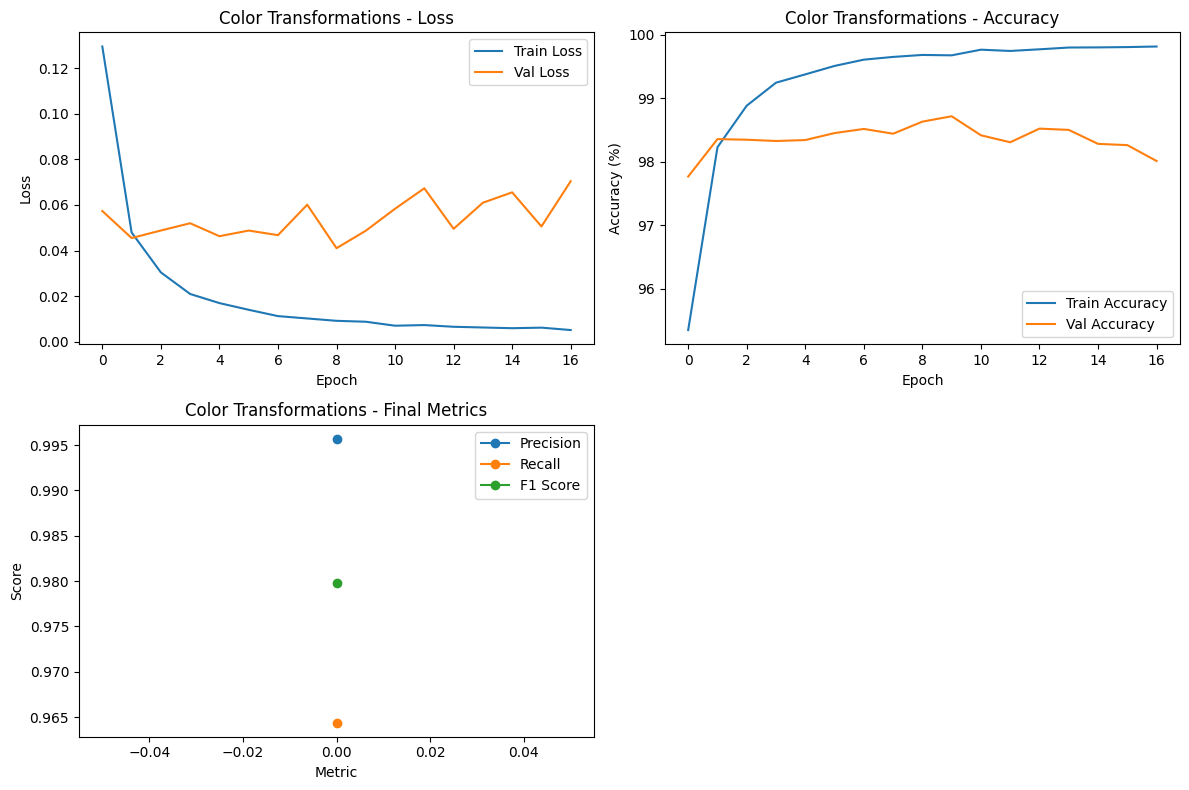

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import os
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification

import warnings
warnings.filterwarnings("ignore")

transform_sets = {
#         "Noise Transformations": transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.GaussianBlur(kernel_size=3),
#             transforms.RandomErasing(),
#         ]),
#         "Basic and Geometric Transformations": transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             transforms.RandomRotation(20),
#             transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
#             transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10),
#         ]),
        "Color Transformations": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ]),
#         "Previous Transforms": transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             transforms.RandomRotation(20),
#             transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#         ]),
#         "Combined Transforms": transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#             transforms.RandomHorizontalFlip(),
#             transforms.RandomVerticalFlip(),
#             transforms.RandomRotation(20),
#             transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#             transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
#             transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
#             transforms.GaussianBlur(kernel_size=3),
#             transforms.RandomErasing(),
#         ]),
        
    }

# Define the transformation sets
def get_transforms(transform_name):

    return transform_sets[transform_name]

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        for label in ['FAKE', 'REAL']:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                self.image_files.append(os.path.join(label_dir, img_name))
                self.labels.append(0 if label == 'FAKE' else 1)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def train_and_evaluate(transform_name, num_epochs=100):
    print(f"Using transformation set: {transform_name}")
    
    transform = get_transforms(transform_name)
    
    train_dataset = CustomDataset('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train', transform=transform)
    val_dataset = CustomDataset('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test', transform=transform)
    
#     train_dataset = CustomDataset('/kaggle/working/train', transform=transform)
#     val_dataset = CustomDataset('/kaggle/working/test', transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    # Define the model, criterion, and optimizer
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize metrics storage
    metrics = {
        "train_losses": [],
        "val_losses": [],
        "train_accuracies": [],
        "val_accuracies": [],
        "final_train_loss": None,
        "final_val_loss": None,
        "final_train_accuracy": None,
        "final_val_accuracy": None,
        "precision" : None,
        "f1" : None,
        "recall" : None
    }

    best_val_loss = float('inf')
    patience = 10
    min_delta = 0.01
    patience_counter = 0
    prev_val_loss = 0
    best_epoch = None

    best_weights_path = f'best_weights_{transform_name}.pth'
    
    # Clean up old best weights
    if os.path.exists(best_weights_path):
        os.remove(best_weights_path)
        print(f"Deleted previous best weights file: {best_weights_path}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_preds = []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        metrics["train_losses"].append(train_loss)
        metrics["train_accuracies"].append(train_accuracy)
    

        print(f"Epoch {epoch+1} Training loss: {train_loss:.4f}, Training accuracy: {train_accuracy:.2f}%")

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        metrics["val_losses"].append(val_loss)
        metrics["val_accuracies"].append(val_accuracy)
    
        print(f"Epoch {epoch+1} Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")
         
#         print(f"Length of all_val_labels: {(all_val_labels)}")
#         print(f"Length of all_val_preds: {(all_val_preds)}")
        
        all_val_labels  = [1 if x > 0.5 else 0 for x in all_val_labels]
        all_val_preds = [1 if x > 0.5 else 0 for x in all_val_preds]
        # Compute precision, recall, and F1 score
      
        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_weights_path)
            print(f"New best model found and saved with validation loss: {val_loss:.4f}")
            patience_counter = 0
            best_epoch = epoch
        elif val_loss >= prev_val_loss:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
        prev_val_loss = val_loss
    # Load the best weights
    model.load_state_dict(torch.load(best_weights_path))
    precision = precision_score(all_val_labels, all_val_preds, average='binary')
    recall = recall_score(all_val_labels, all_val_preds, average='binary')
    f1 = f1_score(all_val_labels, all_val_preds, average='binary')
    print(f"Epoch {epoch+1} Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store final metrics
    metrics["final_train_loss"] = train_loss
    metrics["final_val_loss"] = val_loss
    metrics["final_train_accuracy"] = train_accuracy
    metrics["final_val_accuracy"] = val_accuracy
    metrics["precision"] = precision
    metrics["f1"] = f1
    metrics["recall"] = recall
    
    return metrics

# Store metrics for all transformation sets
all_metrics = {}

for name in transform_sets.keys():
    metrics = train_and_evaluate(name)
    all_metrics[name] = metrics

# Print the metrics with transformation set name
for name, metrics in all_metrics.items():
    print(f"Metrics for transformation set: {name}")
    print(f"  Final Training Loss: {metrics['final_train_loss']:.4f}")
    print(f"  Final Validation Loss: {metrics['final_val_loss']:.4f}")
    print(f"  Final Training Accuracy: {metrics['final_train_accuracy']:.2f}%")
    print(f"  Final Validation Accuracy: {metrics['final_val_accuracy']:.2f}%")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print()

# Plotting
for name, metrics in all_metrics.items():
    plt.figure(figsize=(12, 8))

    # Plot training and validation losses
    plt.subplot(2, 2, 1)
    plt.plot(metrics["train_losses"], label="Train Loss")
    plt.plot(metrics["val_losses"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{name} - Loss")
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(2, 2, 2)
    plt.plot(metrics["train_accuracies"], label="Train Accuracy")
    plt.plot(metrics["val_accuracies"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{name} - Accuracy")
    plt.legend()

    # Plot precision, recall, and F1 score (final values)
    plt.subplot(2, 2, 3)
    plt.plot([metrics["precision"]], label="Precision", marker='o')
    plt.plot([metrics["recall"]], label="Recall", marker='o')
    plt.plot([metrics["f1"]], label="F1 Score", marker='o')
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title(f"{name} - Final Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Save final metrics
import json
with open('final_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)


# Convnext experiment

In [ ]:
import torchvision.transforms as transforms

# Define each transformation set as per your requirement
transform_sets = {
   "Previous Transforms": transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT model's input size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip images vertically
    transforms.RandomRotation(20),  # Randomly rotate images by up to 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Apply random color adjustments
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize using the mean and std
]),
    "Combined Transforms": transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),

     "Noise Transformations": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),    
    "Basic and Geometric Transformations": transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10),
        transforms.ToTensor(),
    ]),
    "Color Transformations": transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
   
}

In [ ]:
from transformers import AutoImageProcessor, ConvNextForImageClassification
import torch
import os
from PIL import Image
from torchvision import transforms
from datasets import load_dataset
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from torch.cuda.amp import GradScaler, autocast

# Define the path for saving best weights
weights_dir = 'best_weights'
os.makedirs(weights_dir, exist_ok=True)

# Initialize the ConvNeXt model and processor
# model_name = "facebook/convnext-tiny-224"
model_name = 'facebook/convnext-base-384-22k-1k'
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = ConvNextForImageClassification.from_pretrained(model_name)

# Define the transformation sets
transform_sets = {
    "Noise Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
    "Basic and Geometric Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10),
    ]),
    "Color Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Previous Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Combined Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
}

# Define the CustomDataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        for label in ['FAKE', 'REAL']:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                self.image_files.append(os.path.join(label_dir, img_name))
                self.labels.append(0 if label == 'FAKE' else 1)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# Train and evaluate function

def train_and_evaluate(transform_name, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    scaler = GradScaler()

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs = [image_processor(image) for image in inputs]
            inputs = torch.stack([torch.tensor(input['pixel_values']) for input in inputs]).to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # End of epoch
        torch.cuda.empty_cache()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct_train / total_train}%")

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = [image_processor(image) for image in inputs]
                inputs = torch.stack([torch.tensor(input['pixel_values']) for input in inputs]).to(device)
                labels = labels.to(device)

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_{transform_name}.pth")
            print(f"Saved best model for {transform_name}")

    return {
        "train_loss": running_loss / len(train_loader),
        "val_loss": val_loss,
        "train_accuracy": 100 * correct_train / total_train,
        "val_accuracy": 100 * correct_val / total_val
    }

# Example of using the transform sets
for transform_name in transform_sets.keys():
    metrics = train_and_evaluate(transform_name)
    print(f"Metrics for {transform_name}: {metrics}")

# Example of using the transform sets
for transform_name in transform_sets.keys():
    metrics = train_and_evaluate(transform_name)
    print(f"Metrics for {transform_name}: {metrics}")


In [ ]:
import torch
torch.cuda.empty_cache()


# ShuffleNet V2

In [ ]:
!pip install qai-hub-models

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import os
from torchvision import transforms
from PIL import Image
from transformers import ViTForImageClassification

import warnings
warnings.filterwarnings("ignore")

transform_sets = {
        "Noise Transformations": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomErasing(),
        ]),
        "Basic and Geometric Transformations": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
            transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10),
        ]),
        "Color Transformations": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ]),
        "Previous Transforms": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        ]),
        "Combined Transforms": transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
            transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomErasing(),
        ]),
        
    }

# Define the transformation sets
def get_transforms(transform_name):

    return transform_sets[transform_name]

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        for label in ['FAKE', 'REAL']:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                self.image_files.append(os.path.join(label_dir, img_name))
                self.labels.append(0 if label == 'FAKE' else 1)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def train_and_evaluate(transform_name, num_epochs=100):
    print(f"Using transformation set: {transform_name}")
    
    transform = get_transforms(transform_name)
    
#     train_dataset = CustomDataset('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train', transform=transform)
#     val_dataset = CustomDataset('/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test', transform=transform)
    
    train_dataset = CustomDataset('/kaggle/working/train', transform=transform)
    val_dataset = CustomDataset('/kaggle/working/test', transform=transform)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

    # Define the model, criterion, and optimizer
    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Initialize metrics storage
    metrics = {
        "train_losses": [],
        "val_losses": [],
        "train_accuracies": [],
        "val_accuracies": [],
        "final_train_loss": None,
        "final_val_loss": None,
        "final_train_accuracy": None,
        "final_val_accuracy": None,
        "precision" : None,
        "f1" : None,
        "recall" : None
    }

    best_val_loss = float('inf')
    patience = 10
    min_delta = 0.01
    patience_counter = 0
    prev_val_loss = 0
    best_epoch = None

    best_weights_path = f'best_weights_{transform_name}.pth'
    
    # Clean up old best weights
    if os.path.exists(best_weights_path):
        os.remove(best_weights_path)
        print(f"Deleted previous best weights file: {best_weights_path}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_train_labels = []
        all_train_preds = []

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(predicted.cpu().numpy())

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        metrics["train_losses"].append(train_loss)
        metrics["train_accuracies"].append(train_accuracy)
    

        print(f"Epoch {epoch+1} Training loss: {train_loss:.4f}, Training accuracy: {train_accuracy:.2f}%")

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs).logits
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(predicted.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        metrics["val_losses"].append(val_loss)
        metrics["val_accuracies"].append(val_accuracy)
    
        print(f"Epoch {epoch+1} Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")
         
#         print(f"Length of all_val_labels: {(all_val_labels)}")
#         print(f"Length of all_val_preds: {(all_val_preds)}")
        
        all_val_labels  = [1 if x > 0.5 else 0 for x in all_val_labels]
        all_val_preds = [1 if x > 0.5 else 0 for x in all_val_preds]
        # Compute precision, recall, and F1 score
      
        # Early stopping
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_weights_path)
            print(f"New best model found and saved with validation loss: {val_loss:.4f}")
            patience_counter = 0
            best_epoch = epoch
        elif val_loss >= prev_val_loss:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break
        prev_val_loss = val_loss
    # Load the best weights
    model.load_state_dict(torch.load(best_weights_path))
    precision = precision_score(all_val_labels, all_val_preds, average='binary')
    recall = recall_score(all_val_labels, all_val_preds, average='binary')
    f1 = f1_score(all_val_labels, all_val_preds, average='binary')
    print(f"Epoch {epoch+1} Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # Store final metrics
    metrics["final_train_loss"] = train_loss
    metrics["final_val_loss"] = val_loss
    metrics["final_train_accuracy"] = train_accuracy
    metrics["final_val_accuracy"] = val_accuracy
    metrics["precision"] = precision
    metrics["f1"] = f1
    metrics["recall"] = recall
    
    return metrics

# Store metrics for all transformation sets
all_metrics = {}

for name in transform_sets.keys():
    metrics = train_and_evaluate(name)
    all_metrics[name] = metrics

# Print the metrics with transformation set name
for name, metrics in all_metrics.items():
    print(f"Metrics for transformation set: {name}")
    print(f"  Final Training Loss: {metrics['final_train_loss']:.4f}")
    print(f"  Final Validation Loss: {metrics['final_val_loss']:.4f}")
    print(f"  Final Training Accuracy: {metrics['final_train_accuracy']:.2f}%")
    print(f"  Final Validation Accuracy: {metrics['final_val_accuracy']:.2f}%")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  F1 Score: {metrics['f1']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print()

# Plotting
for name, metrics in all_metrics.items():
    plt.figure(figsize=(12, 8))

    # Plot training and validation losses
    plt.subplot(2, 2, 1)
    plt.plot(metrics["train_losses"], label="Train Loss")
    plt.plot(metrics["val_losses"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{name} - Loss")
    plt.legend()

    # Plot training and validation accuracies
    plt.subplot(2, 2, 2)
    plt.plot(metrics["train_accuracies"], label="Train Accuracy")
    plt.plot(metrics["val_accuracies"], label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{name} - Accuracy")
    plt.legend()

    # Plot precision, recall, and F1 score (final values)
    plt.subplot(2, 2, 3)
    plt.plot([metrics["precision"]], label="Precision", marker='o')
    plt.plot([metrics["recall"]], label="Recall", marker='o')
    plt.plot([metrics["f1"]], label="F1 Score", marker='o')
    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title(f"{name} - Final Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Save final metrics
import json
with open('final_metrics.json', 'w') as f:
    json.dump(all_metrics, f, indent=4)


# SqueezeNet v3

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch
import os
from torchvision import transforms, models
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

transform_sets = {
    "Noise Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
    "Basic and Geometric Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10),
    ]),
    "Color Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Previous Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Combined Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
}

# Define the transformation sets
def get_transforms(transform_name):
    return transform_sets[transform_name]

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []
        
        for label in ['FAKE', 'REAL']:
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                self.image_files.append(os.path.join(label_dir, img_name))
                self.labels.append(0 if label == 'FAKE' else 1)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def train_and_evaluate(transform_name, num_epochs=100):
        print(f"Using transformation set: {transform_name}")

        transform = get_transforms(transform_name)

        # Paths for the datasets
        train_dataset = CustomDataset('/kaggle/working/train', transform=transform)
        val_dataset = CustomDataset('/kaggle/working/test', transform=transform)

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)

        # Define the model, criterion, and optimizer
        model = models.squeezenet1_1(pretrained=False)  # Initialize the model
        model.load_state_dict(torch.load('/kaggle/input/squeezenet-weights/squeezeNet_9.pt', map_location=torch.device('cpu')))  # Load the pretrained weights
        model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)  # Adjust the classifier for 2 classes

        optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
        criterion = torch.nn.CrossEntropyLoss()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        # Initialize metrics storage
        metrics = {
            "train_losses": [],
            "val_losses": [],
            "train_accuracies": [],
            "val_accuracies": [],
            "final_train_loss": None,
            "final_val_loss": None,
            "final_train_accuracy": None,
            "final_val_accuracy": None,
            "precision" : None,
            "f1" : None,
            "recall" : None
        }

        best_val_loss = float('inf')
        patience = 10
        min_delta = 0.01
        patience_counter = 0
        prev_val_loss = 0
        best_epoch = None

        best_weights_path = f'best_weights_{transform_name}.pth'

        # Clean up old best weights
        if os.path.exists(best_weights_path):
            os.remove(best_weights_path)
            print(f"Deleted previous best weights file: {best_weights_path}")

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            all_train_labels = []
            all_train_preds = []

            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)[0]  # Get the logits
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                all_train_labels.extend(labels.cpu().numpy())
                all_train_preds.extend(predicted.cpu().numpy())

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct_train / total_train

            metrics["train_losses"].append(train_loss)
            metrics["train_accuracies"].append(train_accuracy)

            print(f"Epoch {epoch+1} Training loss: {train_loss:.4f}, Training accuracy: {train_accuracy:.2f}%")

            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0
            all_val_labels = []
            all_val_preds = []

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)[0]  # Get the logits
                    loss = criterion(outputs, labels)

                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()
                    all_val_labels.extend(labels.cpu().numpy())
                    all_val_preds.extend(predicted.cpu().numpy())

            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * correct_val / total_val

            metrics["val_losses"].append(val_loss)
            metrics["val_accuracies"].append(val_accuracy)

            print(f"Epoch {epoch+1} Validation loss: {val_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

            # Compute precision, recall, and F1 score
            precision = precision_score(all_val_labels, all_val_preds, average='binary')
            recall = recall_score(all_val_labels, all_val_preds, average='binary')
            f1 = f1_score(all_val_labels, all_val_preds, average='binary')
            print(f"Epoch {epoch+1} Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

            # Early stopping
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_weights_path)
                print(f"New best model found and saved with validation loss: {val_loss:.4f}")
                patience_counter = 0
                best_epoch = epoch
            elif val_loss >= prev_val_loss:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch+1} epochs.")
                    break
            prev_val_loss = val_loss

        # Load the best weights
        model.load_state_dict(torch.load(best_weights_path, map_location=torch.device('cpu')))
        precision = precision_score(all_val_labels, all_val_preds, average='binary')
        recall = recall_score(all_val_labels, all_val_preds, average='binary')
        f1 = f1_score(all_val_labels, all_val_preds, average='binary')

        metrics["final_train_loss"] = train_loss
        metrics["final_val_loss"] = val_loss
        metrics["final_train_accuracy"] = train_accuracy
        metrics["final_val_accuracy"] = val_accuracy
        metrics["precision"] = precision
        metrics["f1"] = f1
        metrics["recall"] = recall

        print(f"Final Training loss: {train_loss:.4f}, Final Training accuracy: {train_accuracy:.2f}%")
        print(f"Final Validation loss: {val_loss:.4f}, Final Validation accuracy: {val_accuracy:.2f}%")
        print(f"Final Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

        # Plot metrics
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(metrics["train_losses"], label='Train Loss')
        plt.plot(metrics["val_losses"], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss Curve')

        plt.subplot(1, 2, 2)
        plt.plot(metrics["train_accuracies"], label='Train Accuracy')
        plt.plot(metrics["val_accuracies"], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title('Accuracy Curve')

        plt.tight_layout()
        plt.show()


# Example usage:
transform_name = "Combined Transforms"
train_and_evaluate(transform_name)


Using transformation set: Combined Transforms


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
from PIL import Image
import os

def get_image_dimensions(image_path):
    """Return the dimensions of an image."""
    with Image.open(image_path) as img:
        return img.size  # Returns (width, height)

def count_image_dimensions(folder_path):
    """Count the occurrences of each image dimension in a folder."""
    dimension_count = {}

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            dimensions = get_image_dimensions(image_path)
            dimension_key = f"{dimensions[0]}x{dimensions[1]}"
            
            print(f"Image: {filename}, Dimensions: {dimension_key}")  # Print dimensions of each image during count

            if dimension_key in dimension_count:
                dimension_count[dimension_key] += 1
            else:
                dimension_count[dimension_key] = 1

    return dimension_count

# Replace 'your_folder_path' with the path to your images folder
# folder_path = '/kaggle/input/dalle-recognition-dataset/real'
folder_path = '/kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2'
dimension_count = count_image_dimensions(folder_path)

for dimension, count in dimension_count.items():
    print(f"{dimension}: {count}")


In [3]:
from PIL import Image
import os

def get_image_dimensions(image_path):
    """Return the dimensions of an image."""
    try:
        with Image.open(image_path) as img:
            return img.size  # Returns (width, height)
    except (OSError, IOError):
        print(f"Skipping problematic image: {image_path}")
        return None

def count_image_dimensions(folder_path):
    """Count the occurrences of each image dimension in a folder."""
    dimension_count = {}

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder_path, filename)
            dimensions = get_image_dimensions(image_path)
            if dimensions:
                dimension_key = f"{dimensions[0]}x{dimensions[1]}"

                if dimension_key in dimension_count:
                    dimension_count[dimension_key] += 1
                else:
                    dimension_count[dimension_key] = 1

    return dimension_count

# Replace 'your_folder_path' with the path to your images folder
folder_path = '/kaggle/input/cifar10-pngs-in-folders/'
dimension_count = count_image_dimensions(folder_path)

for dimension, count in dimension_count.items():
    print(f"{dimension}: {count}")


Augmented images saved to /kaggle/working/augmented_images


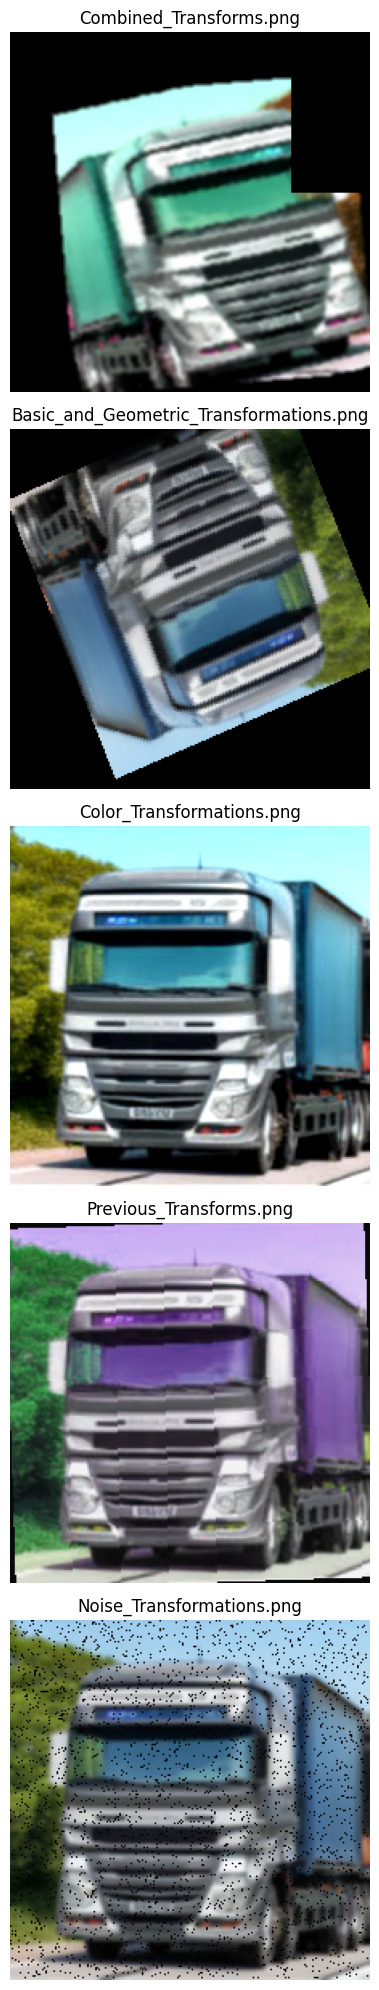

In [17]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch

# Define the transformations
transform_sets = {
    "Noise Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
        lambda x: salt_and_pepper_noise(transforms.ToPILImage()(x))  # Add salt and pepper noise
    ]),
    "Basic and Geometric Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10),
    ]),
    "Color Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Previous Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Combined Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
}

def salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt and pepper noise to an image."""
    img_array = np.array(image)
    total_pixels = img_array.size
    num_salt = np.ceil(salt_prob * img_array.size)
    num_pepper = np.ceil(pepper_prob * img_array.size)
    
    # Add salt noise
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img_array.shape]
    img_array[salt_coords[0], salt_coords[1], :] = 1

    # Add pepper noise
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img_array.shape]
    img_array[pepper_coords[0], pepper_coords[1], :] = 0

    return Image.fromarray(img_array)

# Create output directory
output_dir = "/kaggle/working/augmented_images"
os.makedirs(output_dir, exist_ok=True)

# Load the image
image_path = "/kaggle/input/fake-truck/faketruck.png"
image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format

# Apply each transformation and save the result
for name, transform in transform_sets.items():
    transformed_image = transform(image)
    
    # Convert tensor to PIL image if needed
    if isinstance(transformed_image, torch.Tensor):
        transformed_image = transforms.ToPILImage()(transformed_image)
    
    # Save the transformed image
    file_path = os.path.join(output_dir, f"{name.replace(' ', '_')}.png")
    transformed_image.save(file_path)

print(f"Augmented images saved to {output_dir}")
import os
import matplotlib.pyplot as plt
from PIL import Image

# Directory containing augmented images
output_dir = "/kaggle/working/augmented_images"

# List all image files in the directory
image_files = [f for f in os.listdir(output_dir) if f.endswith('.png')]

# Number of images to display
num_images = len(image_files)

# Create subplots
fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 4))

# Display images
for i, image_file in enumerate(image_files):
    image_path = os.path.join(output_dir, image_file)
    image = Image.open(image_path)
    axes[i].imshow(image)
    axes[i].set_title(image_file)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [16]:
import os

# Directory to clear
output_dir = "/kaggle/working/augmented_images"

# List all files and directories in the specified directory
files = os.listdir(output_dir)

# Loop through the files and delete each one
for file in files:
    file_path = os.path.join(output_dir, file)
    if os.path.isfile(file_path):
        os.remove(file_path)
    elif os.path.isdir(file_path):
        # Recursively delete directory
        import shutil
        shutil.rmtree(file_path)

print("Directory cleared.")


Directory cleared.


Augmented images saved to working directory


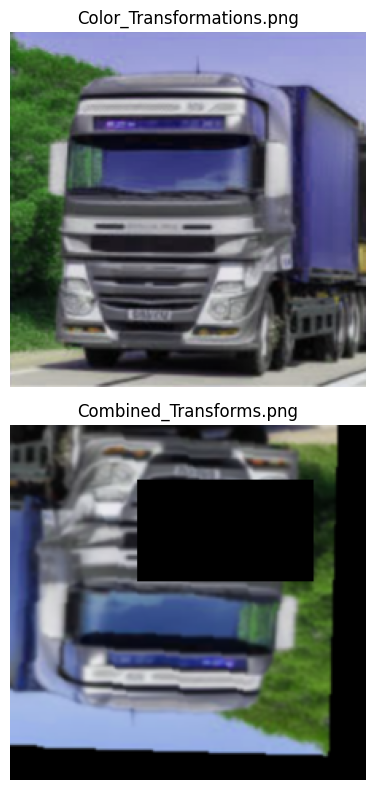

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch

# Define the transformations
transform_sets = {
    "Color Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Combined Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
}

def salt_and_pepper_noise(image, salt_prob=0.01, pepper_prob=0.01):
    """Add salt and pepper noise to an image."""
    img_array = np.array(image)
    total_pixels = img_array.size
    num_salt = np.ceil(salt_prob * img_array.size)
    num_pepper = np.ceil(pepper_prob * img_array.size)
    
    # Add salt noise
    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in img_array.shape]
    img_array[salt_coords[0], salt_coords[1], :] = 1

    # Add pepper noise
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in img_array.shape]
    img_array[pepper_coords[0], pepper_coords[1], :] = 0

    return Image.fromarray(img_array)

# Load the image
image_path = "/kaggle/input/fake-truck/faketruck.png"
image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format

# Create a list to store image file paths
image_file_paths = []

# Apply each transformation and save the result
for name, transform in transform_sets.items():
    transformed_image = transform(image)
    
    # Convert tensor to PIL image if needed
    if isinstance(transformed_image, torch.Tensor):
        transformed_image = transforms.ToPILImage()(transformed_image)
    
    # Save the transformed image
    file_path = f"/kaggle/working/{name.replace(' ', '_')}.png"
    transformed_image.save(file_path)
    image_file_paths.append(file_path)

print(f"Augmented images saved to working directory")

# Display images
num_images = len(image_file_paths)

# Create subplots
fig, axes = plt.subplots(num_images, 1, figsize=(10, num_images * 4))

# Display images
for i, image_file in enumerate(image_file_paths):
    image = Image.open(image_file)
    axes[i].imshow(image)
    axes[i].set_title(os.path.basename(image_file))
    axes[i].axis('off')

plt.tight_layout()
plt.show()


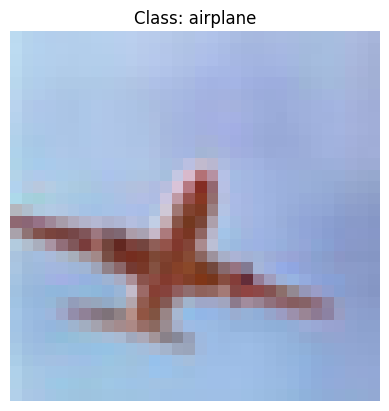

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/airplane/0566.png to /kaggle/working/processed_images/airplane_0566.png


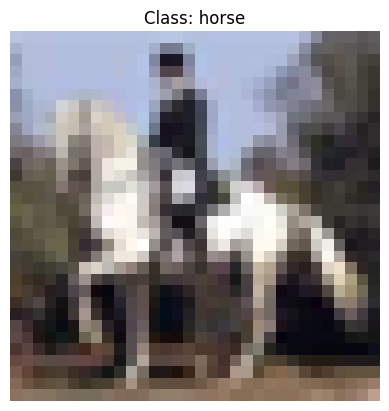

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/horse/0566.png to /kaggle/working/processed_images/horse_0566.png


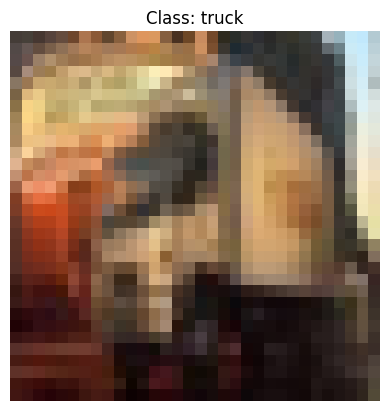

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/truck/0566.png to /kaggle/working/processed_images/truck_0566.png


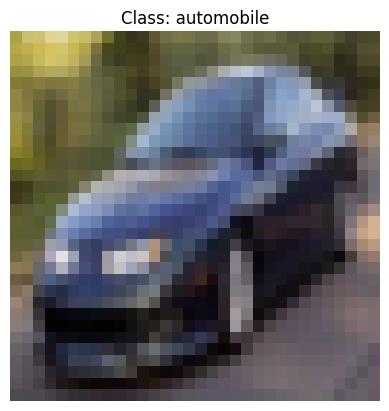

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/automobile/0566.png to /kaggle/working/processed_images/automobile_0566.png


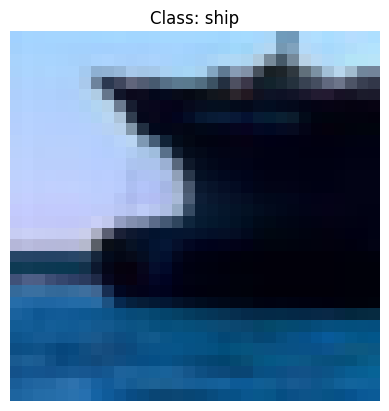

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/ship/0566.png to /kaggle/working/processed_images/ship_0566.png


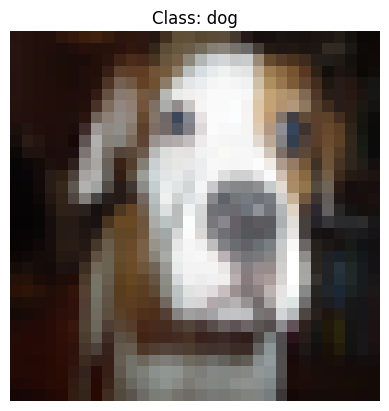

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/dog/0566.png to /kaggle/working/processed_images/dog_0566.png


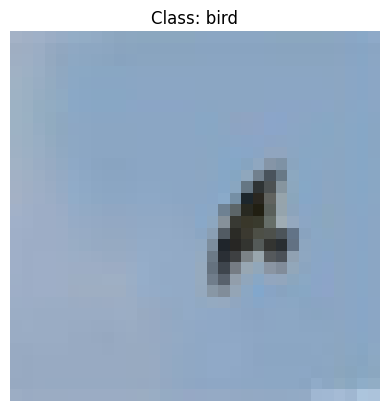

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/bird/0566.png to /kaggle/working/processed_images/bird_0566.png


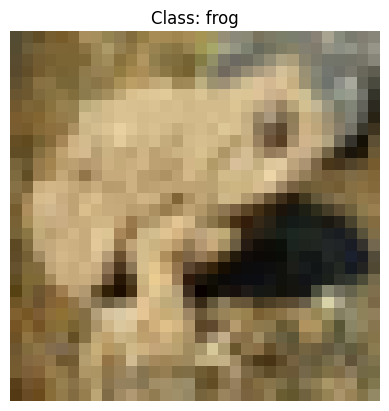

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/frog/0566.png to /kaggle/working/processed_images/frog_0566.png


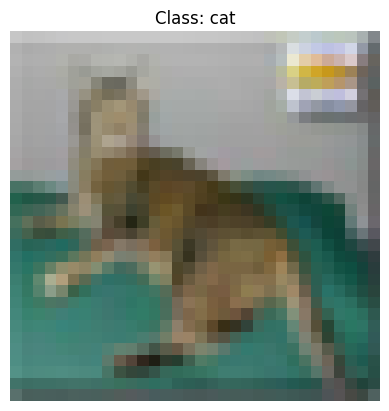

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/cat/0566.png to /kaggle/working/processed_images/cat_0566.png


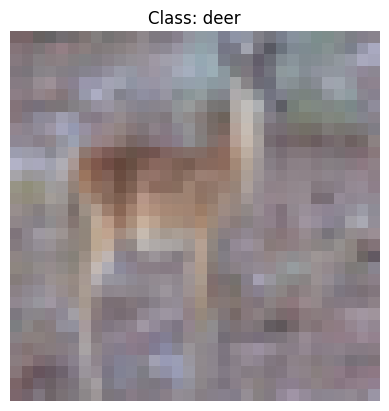

Copied /kaggle/input/cifar10-pngs-in-folders/cifar10/test/deer/0566.png to /kaggle/working/processed_images/deer_0566.png


In [3]:
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
input_dir = '/kaggle/input/cifar10-pngs-in-folders/cifar10/test'
output_dir = '/kaggle/working/processed_images/'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# List all subdirectories (classes) in the input directory
classes = os.listdir(input_dir)

# Iterate over each directory and process one image
for cls in classes:
    cls_dir = os.path.join(input_dir, cls)
    if os.path.isdir(cls_dir):
        # Get a list of image files in the directory
        image_files = os.listdir(cls_dir)
        if image_files:
            # Take the first image file
            image_file = image_files[0]
            image_path = os.path.join(cls_dir, image_file)
            
            # Open and display the image
            with Image.open(image_path) as img:
                plt.imshow(img)
                plt.title(f'Class: {cls}')
                plt.axis('off')
                plt.show()
                
                # Save the image to the output directory
                output_image_path = os.path.join(output_dir, f'{cls}_{image_file}')
                shutil.copy(image_path, output_image_path)
                print(f'Copied {image_path} to {output_image_path}')


In [20]:
import shutil
import os

# Paths
dir_to_zip = '/kaggle/working/augmented_images'
zip_file_path = '/kaggle/working/processed_images.zip'

# Zip the directory
shutil.make_archive('/kaggle/working/processed_images', 'zip', dir_to_zip)

# Confirm the zip file creation
if os.path.exists(zip_file_path):
    print(f'Zip file created: {zip_file_path}')
else:
    print('Failed to create the zip file.')


Zip file created: /kaggle/working/processed_images.zip


In [11]:
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# Define the transformations
transform_sets = {
    "Noise Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
    "Basic and Geometric Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10),
    ]),
    "Color Transformations": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Previous Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    "Combined Transforms": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0)),
        transforms.GaussianBlur(kernel_size=3),
        transforms.RandomErasing(),
    ]),
}

# Load the image
image_path = "/kaggle/input/fake-truck/faketruck.png"
image = Image.open(image_path).convert("RGB")  # Ensure image is in RGB format

# Save original image
image.save("/kaggle/working/original_image.png")

# Apply each transformation and save/display the result
for name, transform in transform_sets.items():
    # Convert image to tensor before applying the transformation
    image_tensor = transforms.ToTensor()(image)
    
    # Apply the transformation
    transformed_tensor = transform(image_tensor)
    
    # Convert tensor back to PIL image
    transformed_image = transforms.ToPILImage()(transformed_tensor)
    
    # Save transformed images
    transformed_image.save(f"/kaggle/working/{name.replace(' ', '_')}.png")
    
    # Display the images
    plt.figure()
    plt.title(f"Transformed: {name}")
    plt.imshow(transformed_image)
    plt.axis('off')
    plt.show()


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>